# Model for each city

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import make_scorer
from sklearn.impute import SimpleImputer
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.backend import abs as KERAS_ABS

# Set global random seed for numpy and sklearn for reproducibility.
np.random.seed(42)

In [3]:
# Important to use utf-8, as 'açaí' will need a better encoding than default ascii
with open('historical-database.csv', 'r', encoding='utf-8') as f:
    data = f.read()

data = data.split('\n')
# Separating columns manually
columns = data[0]
data = data[1:-1]
# Remove ending comma, then split by semi-colon
columns = columns[:-1].split(';')

# Transform dates
def date_handler(date: pd.Timestamp):
    return date.year - 1974

def process_line(line: str) -> list:
    entries = line.split(';')
    if ',' in entries[-1] and len(entries[-1])>1:
        entries[-1] = float(entries[-1].replace(',','.',-1))
    elif len(entries[-1]) <= 1:
        entries[-1] = None
    else:
        entries[-1] = float(entries[-1])
    # Convert to python-friendly date format.
    entries[0] = datetime.datetime.strptime(entries[0],"%d/%m/%Y")
    return entries
data = list(map(process_line, data))
df = pd.DataFrame(data=data, columns=columns)
df['year'] = df['year'].apply(date_handler)
df


,year,city_code,product_type,product,destinated_area
0,0,960b4f2c94a2fb2c,temporary,Others,0.0000
1,0,746cc42bfb8f6b62,temporary,Others,0.0000
2,0,6cce2bf873870afc,temporary,Others,0.0000
3,0,4de42e351006a2ae,temporary,Others,0.0000
4,0,5b6072f8f6d37acc,temporary,Others,0.0000
...,...,...,...,...,...
73739,39,74d75dde6dc4a5ec,pasture,Livestock,150866.5644
73740,40,74d75dde6dc4a5ec,pasture,Livestock,152446.3960
73741,41,74d75dde6dc4a5ec,pasture,Livestock,154681.0205
73742,42,74d75dde6dc4a5ec,pasture,Livestock,164706.2778


In [4]:
# Separating df by city
def df_for_city(city_code: str) -> pd.DataFrame:
    global df
    return df[df['city_code'] == city_code]

# Transform to set, just to ensure non-repetition
unique_city_codes = list(set(df['city_code']))

In [5]:
df.isna().sum(axis=0)

year                   0
city_code              0
product_type           0
product                0
destinated_area    39035
dtype: int64

In [6]:
def WMAPE(y_true, y_pred):
    error = y_true - y_pred
    abs_error = KERAS_ABS(error)
    print(error)
    return abs_error/KERAS_ABS(y_true)

def construct_model(curr_city_code: str):
    curr_df = df_for_city(curr_city_code).drop('city_code', axis=1) #Remove city_code (all rows are the same city)
    # curr_df = curr_df.dropna(axis=0)
    TRAIN = curr_df[curr_df['year'] < date_handler(pd.Timestamp(2016,1,1))]
    TEST = curr_df[curr_df['year'] >= date_handler(pd.Timestamp(2016,1,1))]
    oh_enc = OneHotEncoder(handle_unknown='ignore')
    imputer = SimpleImputer(strategy='median')
    enc = oh_enc.fit_transform(TRAIN.drop('destinated_area', axis=1)[['product_type', 'product']]).toarray()
    X_train = np.concatenate((TRAIN.drop('destinated_area', axis=1)[['year']], enc), axis = 1)
    y_train = TRAIN[['destinated_area']]
    y_train = imputer.fit_transform(y_train)
    enc = oh_enc.transform(TEST.drop('destinated_area', axis=1)[['product_type', 'product']]).toarray()
    X_test = np.concatenate((TEST.drop('destinated_area', axis=1)[['year']], enc), axis = 1)
    y_test = imputer.transform(TEST[['destinated_area']])
    nn = tf.keras.models.Sequential(
        [Dense(200, input_shape=[15,], activation="relu"),
        Dense(200, activation="relu"),
        Dense(100, activation="relu"),
        Dense(50, activation="relu"),
        Dense(20, activation="relu"),
        Dense(1, activation="relu")]
    )
    nn.compile(
        loss='mape',
        optimizer="sgd",
        metrics=["accuracy"],
    )
    history = nn.fit(X_train, y_train, epochs=10, verbose=False)
    return min(history.history['loss']), nn

losses = {}
models = {}
# Iterating through cities to construct individual models.
for curr_city_code in unique_city_codes:
    try:
        loss, model = construct_model(curr_city_code)
        losses[curr_city_code] = loss
        models[curr_city_code] = model
    except Exception as e:
        print(curr_city_code)
        print(e)
        break

746cc42bfb8f6b62
in user code:

    File "d:\Python\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "d:\Python\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Python\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "d:\Python\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "d:\Python\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Python\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_10" is incompat

In [117]:
def show_crops(curr_df: pd.DataFrame):
    '''
    Show every crop's progression over every year on the database.
    '''
    fig = plt.figure(figsize=(16,20))
    axList = []
    for i, prod in enumerate(list(curr_df['product'].value_counts().index)):
        print(i, prod)
        sub_df = curr_df[curr_df['product'] == prod][['destinated_area','year']].sort_values('year', ascending=True)
        axList.append(fig.add_subplot(4,3,i+1))
        axList[i].set_title(prod)
        axList[i].plot(sub_df['year'], sub_df['destinated_area'])
    fig.show()

def construct_city_db(curr_city_code: str) -> pd.DataFrame:
    '''
    Given a city code, extract all lines for that city, convert "Other" product to thei subtypes and drop useless columns
    '''
    curr_df = df_for_city(curr_city_code).drop('city_code', axis=1)
    curr_df.loc[(curr_df['product_type'] == "permanent") & (curr_df['product'] == 'Others'), 'product'] = 'Permanent-other'
    curr_df.loc[(curr_df['product_type'] == "temporary") & (curr_df['product'] == 'Others'), 'product'] = 'Temporary-other'
    curr_df = curr_df.drop('product_type', axis = 1)
    return curr_df

def treat_missing(df_a: pd.DataFrame) -> pd.DataFrame:
    '''
    Given a dataframe for a single city, treat all missing values as best as possible;
    '''
    dfs=[]
    for i, prod in enumerate(list(db_a['product'].value_counts().index)):
            # Extract relevant columns for this product
            sub_df = db_a[db_a['product'] == prod].sort_values('year')
            # Determine how many points are missing
            null_values = sub_df['destinated_area'].isna().sum()
            # If all points are missing, assume always 0
            if null_values == len(list(sub_df.index)):
                    sub_df.loc[sub_df['product'] == prod,'destinated_area'] = 0
                    # print(prod, null_values, sub_df)
            # If you have some data, interpolate to determine missing points in between
            if null_values != 0:
                    # Interpolate where possible
                    sub_df = sub_df.interpolate(axis=0)
                    # Fill with 0 where can't extrapolate
                    sub_df = sub_df.fillna(0.0)
            dfs.append(sub_df)
    return pd.concat(dfs)   
            


0 Temporary-other
1 Rice
2 Beans
3 Cassava
4 Corn
5 Soy
6 Sorghum
7 Permanent-other
8 Palm oil
9 Açaí
10 Cocoa
11 Livestock


C:\Users\cadud\AppData\Local\Temp\ipykernel_11740\3090357501.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


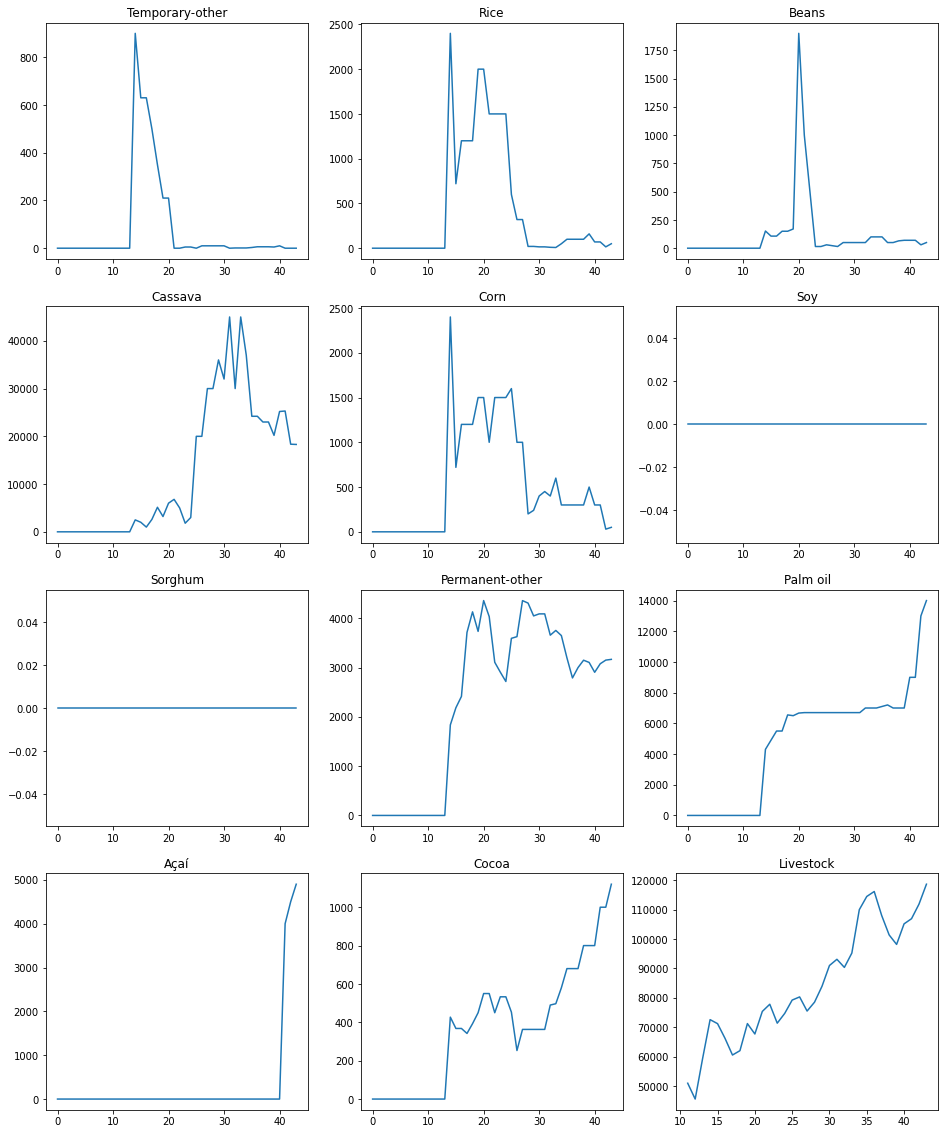

In [118]:
curr_city_code = unique_city_codes[0]
db_a = construct_city_db(curr_city_code)
db_a = treat_missing(db_a)
show_crops(db_a)